In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
from install import *
install_requirements(is_chapter6=True)

⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v2.0.0


In [3]:
# hide
from transformers import pipeline, set_seed

In [4]:
import gc

# Summarization

## The CNN/DailyMail Dataset

In [38]:
#hide_output
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [40]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay. The fastest man in the world charged clear of United States rival Justin
Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel
Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds
with Canada taking the bronze after Britain were disqualified for a faulty
handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


## Text Summarization Pipelines

In [41]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
#hide_output
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

### Summarization Baseline


In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [ ]:
#hide_output
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

In [ ]:
del pipe
gc.collect()

### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="images/chapter08_t5.png" id="T5"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
del pipe
gc.collect()

### BART

In [ ]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
del pipe
gc.collect()

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="images/chapter08_pegasus.png" id="pegasus"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [ ]:
# del pipe
# gc.collect()

## Comparing Different Summaries

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

## Measuring the Quality of Generated Text

### BLEU

In [6]:
# hide_output
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

In [ ]:
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is sleeping"])
results = bleu_metric.compute(smooth_method="floor")
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

### ROUGE

In [7]:
# hide_output
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [44]:
# hide
# ignore this cell it is only to be able to start running the notebook here
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

Let's run it on PEGASUS.

In [9]:
from tqdm import tqdm
import torch

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list of elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [11]:
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="article", column_summary="highlights"):
    """Evaluate summarisation performance usinge PEGASUS."""
    # Get article and target batches
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    # Generation loop
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)
    ):
        
        # Get inputs
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        
        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8, max_length=128
        )
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [ ]:
# from tqdm import tqdm
# import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"

# def chunks(list_of_elements, batch_size):
#     """Yield successive batch-sized chunks from list_of_elements."""
#     for i in range(0, len(list_of_elements), batch_size):
#         yield list_of_elements[i : i + batch_size]

# def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
#                                batch_size=16, device=device, 
#                                column_text="article", 
#                                column_summary="highlights"):
#     article_batches = list(chunks(dataset[column_text], batch_size))
#     target_batches = list(chunks(dataset[column_summary], batch_size))

#     for article_batch, target_batch in tqdm(
#         zip(article_batches, target_batches), total=len(article_batches)):
        
#         inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
#                         padding="max_length", return_tensors="pt")
        
#         summaries = model.generate(input_ids=inputs["input_ids"].to(device),
#                          attention_mask=inputs["attention_mask"].to(device), 
#                          length_penalty=0.8, num_beams=8, max_length=128)
        
#         decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
#                                 clean_up_tokenization_spaces=True) 
#                for s in summaries]
#         decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
#         metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
#     score = metric.compute()
#     return score

In [12]:
# Import tokenizer and model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

# Score
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# # hide_output
# from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# model_ckpt = "google/pegasus-cnn_dailymail"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
# score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
#                                    model, tokenizer, batch_size=8)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["pegasus"])

## Training a Summarization Model

In [13]:
# hide_output
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [14]:
# hide_input
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### Evaluating PEGASUS on SAMSum

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

In [ ]:
# hide_output
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

### Fine-Tuning PEGASUS

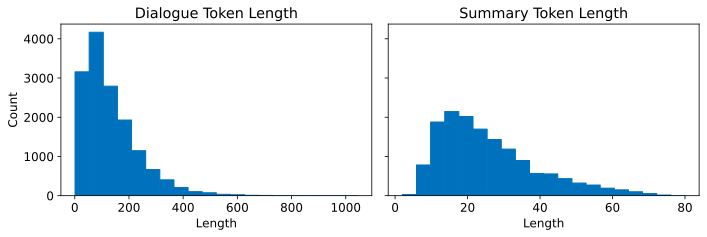

In [15]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [16]:
# Convert examples into features
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
        
    return {
        "input_ids" : input_encodings["input_ids"],
        "attention_mask" : input_encodings["attention_mask"],
        "labels" : target_encodings["input_ids"]
    }

In [17]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
columns = ["input_ids", "attention_mask", "labels"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [19]:
# #hide_output
# def convert_examples_to_features(example_batch):
#     input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
#                                 truncation=True)
    
#     with tokenizer.as_target_tokenizer():
#         target_encodings = tokenizer(example_batch["summary"], max_length=128,
#                                      truncation=True)
    
#     return {"input_ids": input_encodings["input_ids"],
#             "attention_mask": input_encodings["attention_mask"],
#             "labels": target_encodings["input_ids"]}

# dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
#                                        batched=True)
# columns = ["input_ids", "labels", "attention_mask"]
# dataset_samsum_pt.set_format(type="torch", columns=columns)

In [20]:
import pandas as pd

In [21]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [23]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [24]:
# from transformers import DataCollatorForSeq2Seq
# seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [25]:
from transformers import TrainingArguments, Trainer

In [26]:
training_args = TrainingArguments(
    output_dir="pegagus-samsum", 
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=1,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1e6
)

In [27]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
#     per_device_train_batch_size=1, per_device_eval_batch_size=1,
#     weight_decay=0.01, logging_steps=10, push_to_hub=True,
#     evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
#     gradient_accumulation_steps=16)

In [28]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [29]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/studio-lab-user/notebooks/pegagus-samsum is already a clone of https://huggingface.co/gcmsrc/pegagus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [30]:
old_collator = trainer.data_collator
trainer.data_collator = lambda data: dict(old_collator(data))

In [31]:
# hide_output
trainer.train()
# score = evaluate_summaries_pegasus(
#     dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
#     batch_size=2, column_text="dialogue", column_summary="summary")

# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary.
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920


{'loss': 3.2499, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.254, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 2.9103, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.068, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.9722, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8745, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.5802, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.2818, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.5891, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.3183, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.5754, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.2183, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.1945, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1925, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0547, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 1.9847, 'learning

The following columns in the evaluation set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


{'loss': 1.6985, 'learning_rate': 5e-05, 'epoch': 0.54}
{'eval_loss': 1.4875578880310059, 'eval_runtime': 32.4732, 'eval_samples_per_second': 25.19, 'eval_steps_per_second': 25.19, 'epoch': 0.54}
{'loss': 1.7565, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6795, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.6976, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.6962, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6896, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6204, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.616, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.6159, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.6177, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.5648, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.5939, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.53



Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 1.5779, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 2430.4611, 'train_samples_per_second': 6.061, 'train_steps_per_second': 0.379, 'train_loss': 1.8288682388222737, 'epoch': 1.0}


TrainOutput(global_step=920, training_loss=1.8288682388222737, metrics={'train_runtime': 2430.4611, 'train_samples_per_second': 6.061, 'train_steps_per_second': 0.379, 'train_loss': 1.8288682388222737, 'epoch': 1.0})

In [35]:
# hide_output
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegagus-samsum
Configuration saved in pegagus-samsum/config.json
Model weights saved in pegagus-samsum/pytorch_model.bin
tokenizer config file saved in pegagus-samsum/tokenizer_config.json
Special tokens file saved in pegagus-samsum/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file runs/Oct03_17-09-54_default/1664817006.856367/events.out.tfevents.1664817006.default.377.5: 100%|#…

Upload file runs/Oct03_17-13-29_default/1664817226.773133/events.out.tfevents.1664817226.default.377.7: 100%|#…

Upload file spiece.model:   2%|1         | 32.0k/1.82M [00:00<?, ?B/s]

Upload file runs/Oct04_09-56-53_default/1664877443.5691528/events.out.tfevents.1664877443.default.100.5: 100%|…

Upload file runs/Oct03_17-14-13_default/1664817270.576018/events.out.tfevents.1664817270.default.377.9: 100%|#…

Upload file runs/Oct04_10-03-26_default/events.out.tfevents.1664877829.default.405.0: 100%|##########| 18.4k/1…

Upload file runs/Oct04_09-56-53_default/1664877593.671029/events.out.tfevents.1664877593.default.100.6: 100%|#…

Upload file runs/Oct03_17-14-13_default/1664817328.474086/events.out.tfevents.1664817328.default.377.11: 100%|…

Upload file runs/Oct04_09-55-29_default/1664877343.1165152/events.out.tfevents.1664877343.default.100.3: 100%|…

Upload file runs/Oct04_10-03-26_default/1664877829.8952804/events.out.tfevents.1664877829.default.405.1: 100%|…

Upload file runs/Oct03_17-24-38_default/1664817903.1457186/events.out.tfevents.1664817903.default.1043.1: 100%…

Upload file runs/Oct03_16-59-18_default/1664816498.1525793/events.out.tfevents.1664816498.default.377.1: 100%|…

Upload file runs/Oct04_09-51-50_default/1664877141.8640563/events.out.tfevents.1664877141.default.100.1: 100%|…

Upload file runs/Oct03_17-14-13_default/events.out.tfevents.1664817328.default.377.10: 100%|##########| 3.73k/…

Upload file runs/Oct03_17-14-13_default/events.out.tfevents.1664817270.default.377.8: 100%|##########| 3.73k/3…

Upload file runs/Oct04_09-55-29_default/events.out.tfevents.1664877343.default.100.2: 100%|##########| 3.73k/3…

Upload file runs/Oct03_17-13-29_default/events.out.tfevents.1664817226.default.377.6: 100%|##########| 3.73k/3…

Upload file runs/Oct03_17-09-54_default/events.out.tfevents.1664817006.default.377.4: 100%|##########| 3.73k/3…

Upload file runs/Oct04_09-56-53_default/events.out.tfevents.1664877443.default.100.4: 100%|##########| 3.73k/3…

Upload file runs/Oct03_17-24-38_default/events.out.tfevents.1664817903.default.1043.0: 100%|##########| 3.73k/…

Upload file runs/Oct04_09-51-50_default/events.out.tfevents.1664877141.default.100.0: 100%|##########| 3.73k/3…

Upload file runs/Oct03_16-59-18_default/events.out.tfevents.1664816498.default.377.0: 100%|##########| 3.73k/3…

Upload file training_args.bin: 100%|##########| 2.73k/2.73k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/gcmsrc/pegagus-samsum
   2bfed6f..52e0a73  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary field:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'args': 'samsum'}}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/gcmsrc/pegagus-samsum
   52e0a73..16f4ad5  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/gcmsrc/pegagus-samsum/commit/52e0a73f13194d6d13fd135bc524d53db83a0244'

In [45]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428814,0.199153,0.340579,0.340539


In [46]:
# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428814,0.199153,0.340579,0.340539


### Generating Dialogue Summaries

In [47]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [57]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [58]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.


## Conclusion